<a href="https://colab.research.google.com/github/dansten/Portfolio/blob/main/birdsipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Basic CNN to classify birds**
Here's a sample notebook exectuing Python code (Tenserflow, Keras etc) to classify objects, in this case 10 different (african) birds, using a convolutional neural network (CNN). 

### **Setup**

In [1]:
# relevant installs 
#!pip install keras_tuner

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation, BatchNormalization
#import keras_tuner as kt
#from keras_tuner import RandomSearch

### **Importing the data**
The data is originally from [this kaggle dataset](https://www.kaggle.com/gpiosenka/100-bird-species/version/45), consisting of 300 classes of african birds, with over 40 000 images. However, due to my laptop not being the best, I decided to only extract ten classes to use in this project. All images are originally 224x224 pixels, but for faster computations I convert them down to 48x48 pixels.

In [3]:
#constants
IMAGE_SIZE = 48 
BATCH_SIZE = 32
CHANNELS= 3
EPOCHS = 50

#importing the data from Google Drive
data_dir = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/birds',
    seed=111,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 658 files belonging to 5 classes.


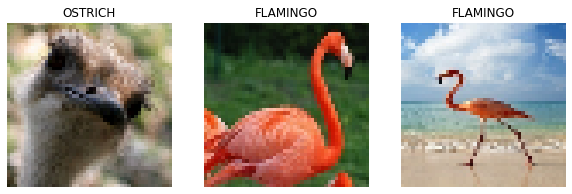

In [4]:
#visualizing parts of the dataset
class_names = data_dir.class_names
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in data_dir.take(1):
    for i in range(3):
        ax = plt.subplot(1, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [5]:
#simple partitioning for our data, to convert it into training, test and validation data.
def partition_data(dataset, train_split, val_split, test_split):
    assert (train_split + test_split + val_split) == 1
    #compute the sizes
    original_size = len(dataset)
    
    train_size = int(train_split * original_size)
    val_size = int(val_split * original_size)
    test_size = int(test_split*original_size)

    #grab the new data
    train_data = dataset.take(train_size)
    val_data = dataset.take(val_size)
    test_data = dataset.take(test_size)
    
    return train_data, val_data, test_data
    
train_data, val_data, test_data = partition_data(data_dir, 0.8, 0.1, 0.1)

### **Preprocessing**
Consists of caching, shuffling and prefetching the data.
We also augment the data (creating more samples by modification of samples data) to, for instance, prevent overfitting.

In [6]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

data_augmentation = Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])
train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

rescale = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/IMAGE_SIZE)]) #normalizing data

### **Creating the model**
I had a general idea for the model by reading papers on the topic (e.g. [this one ](https://www.mdpi.com/2076-3417/8/11/2089)), but to generate a good model quickly, I opted for the keras-tuner package, which helps optimize all the configurable paramteters. 
Note: I did spend quite some time trying different models before turning to keras-tuner.

In [7]:
model = Sequential()
model.add(rescale)

model.add(Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,  kernel_size = (3,3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy']
)

In [8]:
history = model.fit(
    train_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose="auto",
    validation_data=val_data,
    shuffle=True
)

Epoch 1/50
16/16 [==============================] - 59s 173ms/step - loss: 1.6958 - accuracy: 0.2305 - val_loss: 1.5824 - val_accuracy: 0.3750
Epoch 2/50
16/16 [==============================] - 2s 128ms/step - loss: 1.5334 - accuracy: 0.3770 - val_loss: 1.5273 - val_accuracy: 0.2500
Epoch 3/50
16/16 [==============================] - 2s 127ms/step - loss: 1.3759 - accuracy: 0.4160 - val_loss: 1.2960 - val_accuracy: 0.4531
Epoch 4/50
16/16 [==============================] - 2s 129ms/step - loss: 1.2074 - accuracy: 0.4688 - val_loss: 1.2420 - val_accuracy: 0.4219
Epoch 5/50
16/16 [==============================] - 2s 127ms/step - loss: 1.2646 - accuracy: 0.4336 - val_loss: 1.2617 - val_accuracy: 0.5312
Epoch 6/50
16/16 [==============================] - 2s 127ms/step - loss: 1.1337 - accuracy: 0.5234 - val_loss: 1.1085 - val_accuracy: 0.4688
Epoch 7/50
16/16 [==============================] - 2s 126ms/step - loss: 1.0374 - accuracy: 0.5352 - val_loss: 1.0060 - val_accuracy: 0.4844
Epoch

### **Results and predictions**
Here follows some progress during the training as well as a showcase of the model.

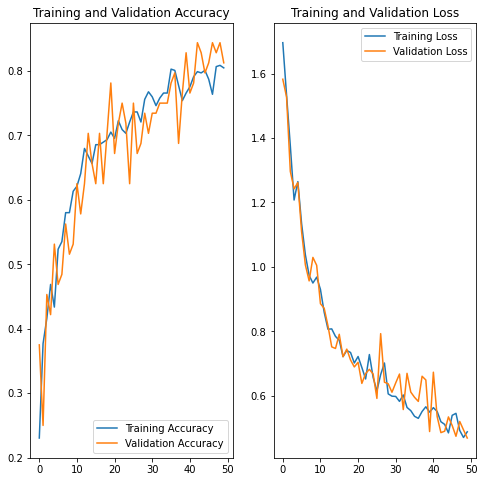

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

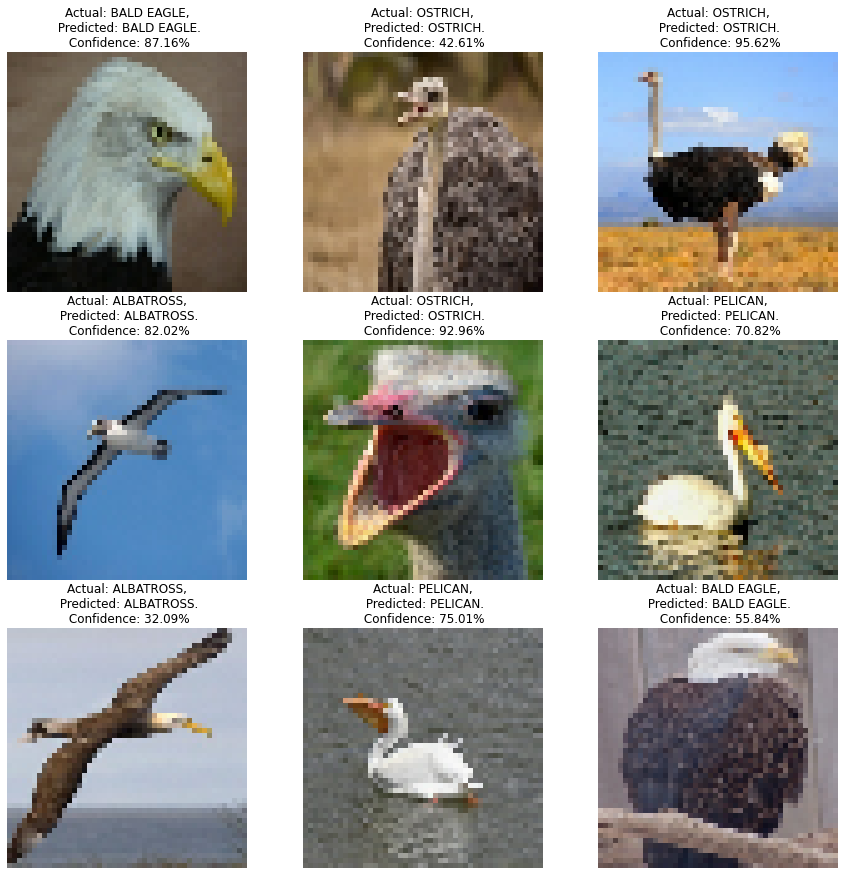

In [10]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")